In [60]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS
from sklearn.linear_model import LinearRegression as LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import tree
import xgboost as xgb
from xgboost import XGBRegressor

Visualization of The Gradient Boosting Classifier: 

In [3]:
#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
#df.shape
#df.head(-1)

In [49]:
df2 = df[df['Time At Sea (Days)'] > 10] #Removes Convoy That Dispersed as these routes contain ships that were orginally part of convoy \
# but were sunk sailing alone.  
df2['High/Low Risk'] = (df2['Overall Sink Percentage'] > 0).astype(int)
df2 = df2.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df2.reset_index(drop=True)
X = np.array(df2.drop(columns=['Overall Sink Percentage', 'High/Low Risk']))
y = df2['High/Low Risk'].values
X_names = ['Number of Ships', 'Number of Escort Ships', 'Number of Stragglers', 'Total Tons of Convoy', 'Avg Number of U-Boats in Atlantic',	
            'Escort Ratio',	'Time At Sea (Days)', 'Month', 'Year', 'Previous Month Avg Sink %', 'Approx. Sighting Range']
y_names = ['High/Low Risk']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.8, random_state=1945)

/var/folders/9n/my6phbv923z13rq9j99h3qz40000gn/T/ipykernel_81642/454535206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['High/Low Risk'] = (df2['Overall Sink Percentage'] > 0).astype(int)


In [5]:
#K-Fold Cross Validation Function
def K_Fold(model, X, y, K, scaler=None, random_state=1945):
    kf = KFold(n_splits=K, random_state=random_state, shuffle=True)
    train_scores = []
    test_scores = []
    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain]
        Xtest = X[idxTest]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        if scaler is not None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)
        model.fit(Xtrain, ytrain)
        train_scores.append(model.score(Xtrain, ytrain))
        test_scores.append(model.score(Xtest, ytest))
    return train_scores, test_scores

In [6]:
#Gradient Boosting Classifier
GB_model_Classifier = GradientBoostingClassifier(random_state=1945)
GB_model_Classifier.fit(Xtrain, ytrain)
ypredict = GB_model_Classifier.predict(Xtest)
GB_mse_Class = mean_squared_error(ytest, ypredict)
print('Gradient Boosting Classifier Train Score (Mean Accuracy):', GB_model_Classifier.score(Xtrain, ytrain))
print('Gradient Boosting Classifier Test Score (Mean Accuracy):', GB_model_Classifier.score(Xtest, ytest))
print('Gradient Boosting Classifier Mean Squared Error', GB_mse_Class)
print('Gradient Boosting Classifier Classification Report: \n', classification_report(ytest, ypredict))
train_scores, test_scores = K_Fold(GB_model_Classifier, X, y, 10, )
print('K-Fold Gradient Boosting Classifier Train Score (Mean Accuracy):', np.mean(train_scores))
print('K-Fold Gradient Boosting Classifier Test Score (Mean Accuracy):',np.mean(test_scores))

Gradient Boosting Classifier Train Score (Mean Accuracy): 0.9487179487179487
Gradient Boosting Classifier Test Score (Mean Accuracy): 0.8693181818181818
Gradient Boosting Classifier Mean Squared Error 0.13068181818181818
Gradient Boosting Classifier Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       141
           1       0.80      0.46      0.58        35

    accuracy                           0.87       176
   macro avg       0.84      0.71      0.75       176
weighted avg       0.86      0.87      0.85       176

K-Fold Gradient Boosting Classifier Train Score (Mean Accuracy): 0.9383702731680776
K-Fold Gradient Boosting Classifier Test Score (Mean Accuracy): 0.8336729362591433


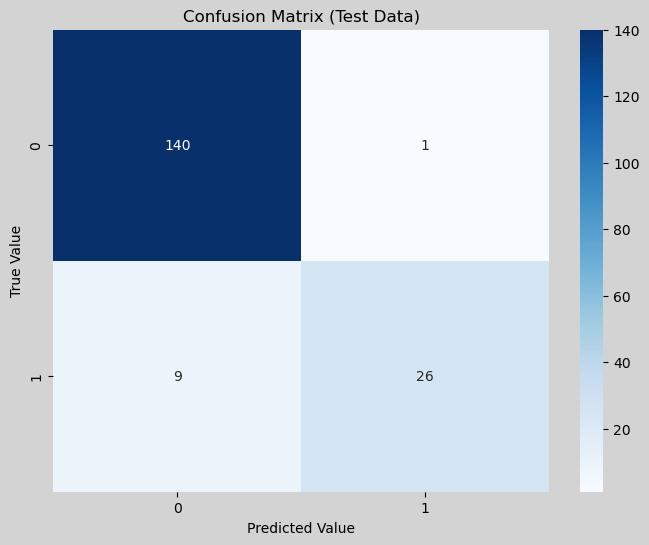

In [46]:
#Plot of Test Data Confusion Matrix
ypredict = GB_model_Classifier.predict(Xtest)
cm = confusion_matrix(ytest, ypredict)
plt.figure(figsize=(8, 6), facecolor='lightgrey')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test Data)')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()


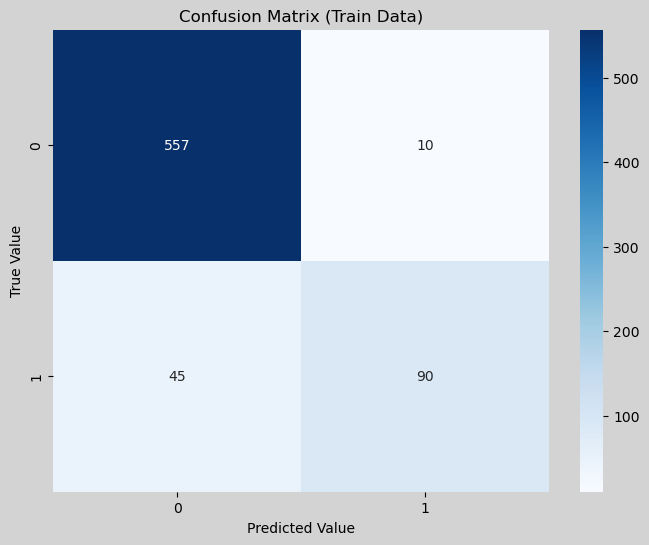

In [73]:
#Plot of Train Data Confusion Matrix
ypredict = GB_model_Classifier.predict(Xtrain)
cm = confusion_matrix(ytrain, ypredict)
plt.figure(figsize=(8, 6), facecolor='lightgrey')
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Train Data)')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

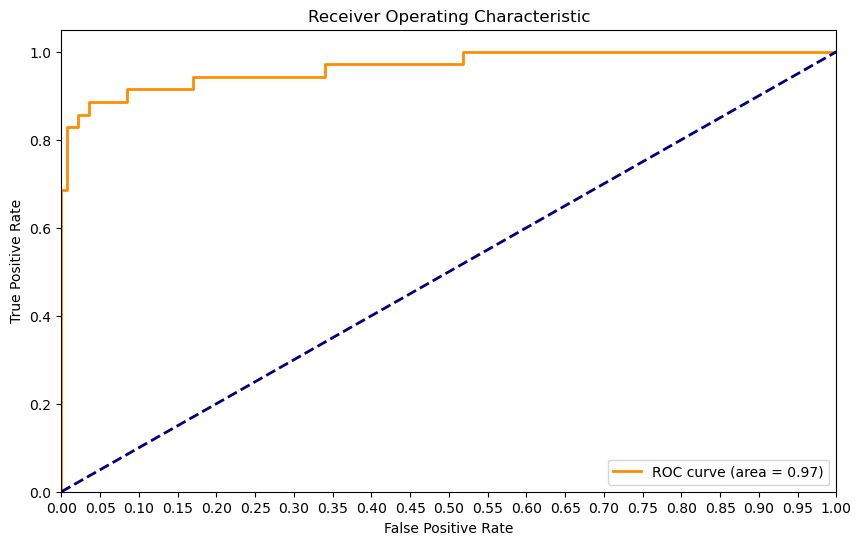

In [53]:
#Incomplete
fpr, tpr, _ = roc_curve(ytest, GB_model_Classifier.predict_proba(Xtest)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1.05, 0.05))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


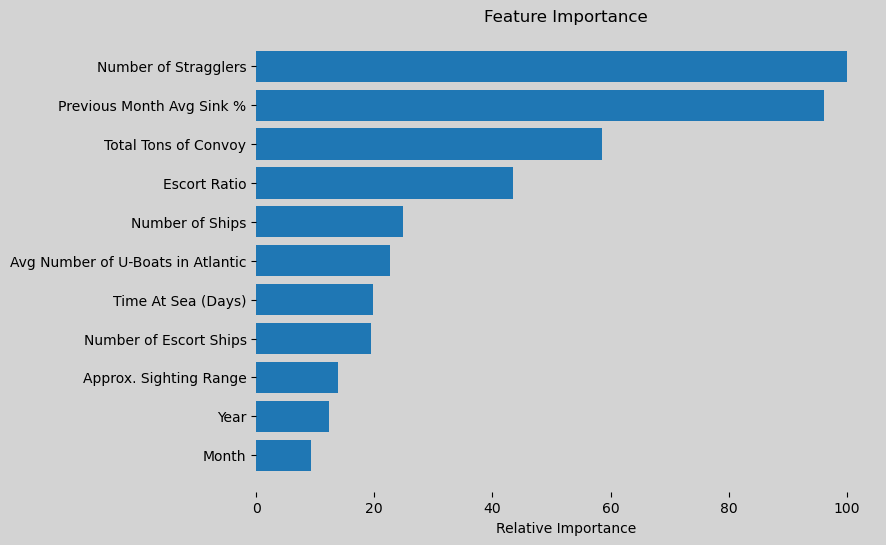

In [35]:
#Plot of Feature Importance
feature_importance = GB_model_Classifier.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig, ax = plt.subplots(figsize=(8, 6), facecolor='lightgrey')
ax.set_facecolor('lightgrey')
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_names)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()



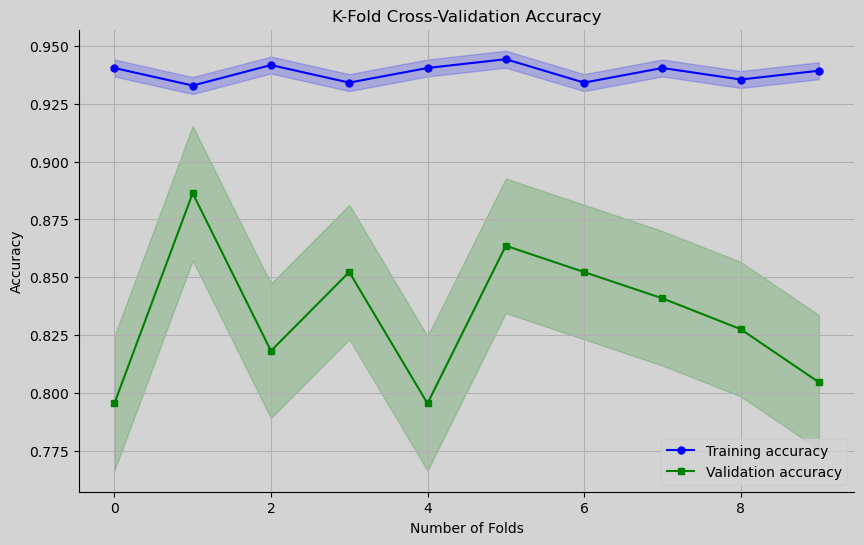

In [43]:
#Plot of K-Fold Cross-Validation Accuracy
train_mean = np.mean(train_scores)
train_std = np.std(train_scores)
test_mean = np.mean(test_scores)
test_std = np.std(test_scores)

fig, ax = plt.subplots(figsize=(10, 6), facecolor='lightgrey')
plt.plot(train_scores, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.plot(test_scores, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(range(len(train_scores)), train_scores - train_std, train_scores + train_std, alpha=0.2, color='blue')
plt.fill_between(range(len(test_scores)), test_scores - test_std, test_scores + test_std, alpha=0.2, color='green')
ax.spines[['right', 'top']].set_visible(False)
ax.set_facecolor('lightgrey')
plt.title('K-Fold Cross-Validation Accuracy')
plt.xlabel('Number of Folds')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', facecolor='lightgrey')
plt.grid()
plt.show()


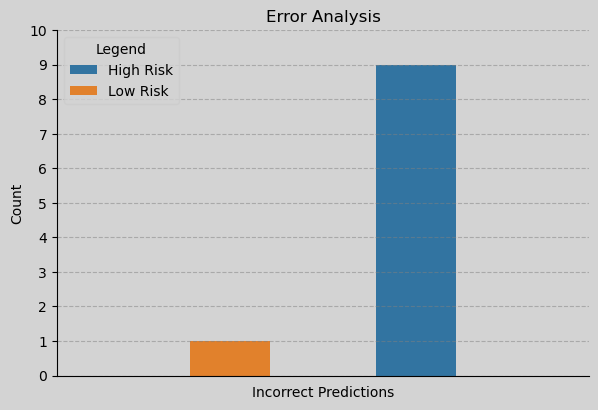

In [70]:
#Plot of Incorrect Predictions
ypredict = GB_model_Classifier.predict(Xtest)
Xtest_df = pd.DataFrame(Xtest, columns=X_names)
Xtest_df['True Value'] = ytest
Xtest_df['Predicted Value'] = ypredict
Xtest_df['Correct'] = Xtest_df['True Value'] == Xtest_df['Predicted Value']
labels = ['High Risk', 'Low Risk']
incorrect_predictions = Xtest_df[Xtest_df['Correct'] == False]
fig, ax = plt.subplots(figsize=(6, 4), facecolor='lightgrey')
ax = sns.countplot(x='True Value', hue='Predicted Value', data=incorrect_predictions, width=0.6)
ax.set_xticks([])
ax.set_facecolor('lightgrey')
ax.grid(axis='y', linestyle='--', color='gray', alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.yticks(np.arange(0, 11, 1))
plt.title('Error Analysis')
plt.xlabel('Incorrect Predictions')
plt.ylabel('Count')
plt.legend(labels, loc='upper left', facecolor='lightgrey', title='Legend')
plt.show()


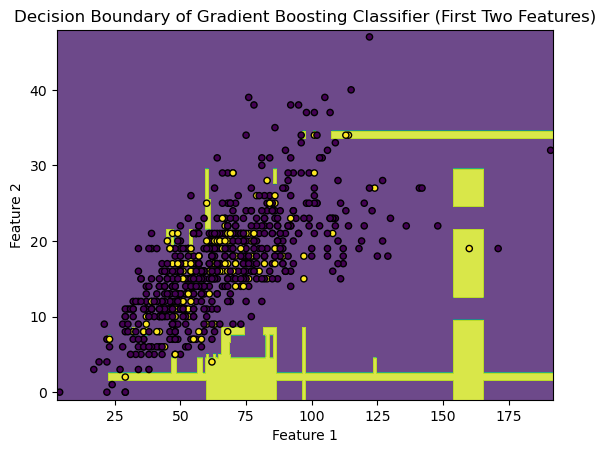

In [26]:
#Needs Work/Not Finished
Xtrain_2d = Xtrain[:, :2]
Xtest_2d = Xtest[:, :2]
GB_model_Classifier_2d = GradientBoostingClassifier(random_state=1945)
GB_model_Classifier_2d.fit(Xtrain_2d, ytrain)
x_min, x_max = Xtrain_2d[:, 0].min() - 1, Xtrain_2d[:, 0].max() + 1
y_min, y_max = Xtrain_2d[:, 1].min() - 1, Xtrain_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = GB_model_Classifier_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(Xtrain_2d[:, 0], Xtrain_2d[:, 1], c=ytrain, edgecolor='k', s=20)
plt.title("Decision Boundary of Gradient Boosting Classifier (First Two Features)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()



[Text(0.5, 0.875, 'Number of Stragglers <= 0.5\nfriedman_mse = 0.158\nsamples = 791\nvalue = -0.0'),
 Text(0.25, 0.625, 'Avg Number of U-Boats in Atlantic <= 101.5\nfriedman_mse = 0.092\nsamples = 568\nvalue = -0.094'),
 Text(0.125, 0.375, 'Year <= 1940.5\nfriedman_mse = 0.078\nsamples = 514\nvalue = -0.11'),
 Text(0.0625, 0.125, 'friedman_mse = 0.178\nsamples = 52\nvalue = 0.221'),
 Text(0.1875, 0.125, 'friedman_mse = 0.064\nsamples = 462\nvalue = -0.804'),
 Text(0.375, 0.375, 'Escort Ratio <= 0.224\nfriedman_mse = 0.192\nsamples = 54\nvalue = 0.063'),
 Text(0.3125, 0.125, 'friedman_mse = 0.0\nsamples = 3\nvalue = 5.103'),
 Text(0.4375, 0.125, 'friedman_mse = 0.169\nsamples = 51\nvalue = 0.125'),
 Text(0.75, 0.625, 'Previous Month Avg Sink % <= 1.54\nfriedman_mse = 0.246\nsamples = 223\nvalue = 0.239'),
 Text(0.625, 0.375, 'Previous Month Avg Sink % <= 0.333\nfriedman_mse = 0.188\nsamples = 140\nvalue = 0.054'),
 Text(0.5625, 0.125, 'friedman_mse = 0.096\nsamples = 74\nvalue = -0.558'

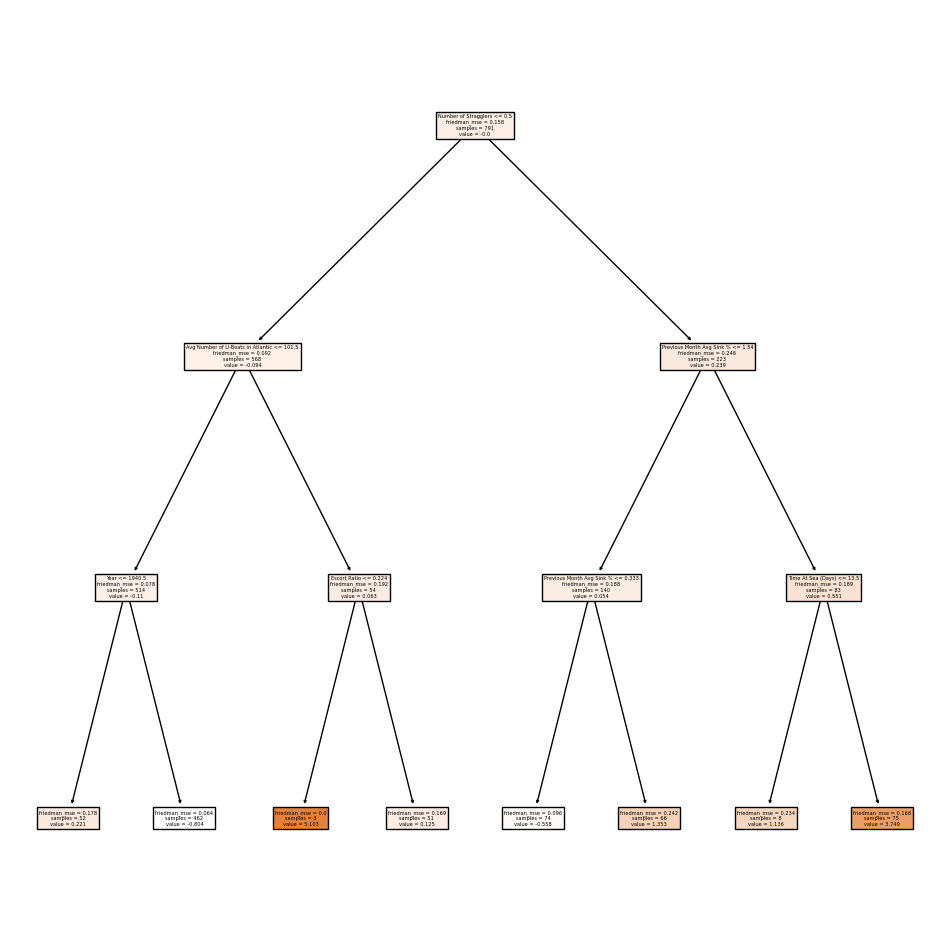

In [61]:
first_tree = GB_model_Classifier.estimators_[0, 0]
plt.figure(figsize=(12, 12))
tree.plot_tree(first_tree, feature_names=X_names, filled=True)